In [1]:
# Import necessary libraries for building and training the model
import torch
from torch import nn


In [2]:
# Define the LeNet2 model architecture based on the original LeNet-2 paper by Yann LeCun.
class LeNet2(nn.Module):
    def __init__(self, ) -> None:
        super().__init__()
        # from the paper (https://dl.acm.org/doi/10.1162/neco.1989.1.4.541):
        # H1 is composed of 12 groups of 64 units arranged as 12 independent 8 by 8 feature maps.
        # (The above line states that we have 12 convolution filters 
        # and the output is 8 by 8 feature maps.
        # It also suggests that somehow downsamling is done.)
        
        # From paper: Each unit in a feature map takes input on a 5 by 5
        # neighborhood on the input plane.
        # (This means use kernel size 5x5)
        
        # From paper: For units in layer H1 that are one unit apart, their receptive 
        # fields (in the input layer) are two pixels apart.
        # Thus, the input image is undersampled and some position information is
        # eliminated.
        # (To me this sounds as use stride=2)
        
        # From paper: Connections extending past the boundaries of
        # the input plane take their input from a virtual background 
        # plane whose state is equal to a constant, predetermined 
        # background level, in our case -1.
        # (this means add padding with set value of -1. 
        # As in Pytorch you cannot modify the padded valeus by defualt to -1 we will omit 
        # this here but the results should be the same.
        # To have 8x8 image with stride kernel_size=5 and stride=2 we need to set padding=2)
        
        # (According to the paper H2 is the same as H1 (but works on smaller feature maps))
        
        # From paper: Layer H3 has 30 units, and is fully connected to H2. The number
        # of connections between H2 and H3 is thus 5790 (30 times 192 plus 30
        # biases). The output layer has 10 units and is also fully connected to H3,
        # adding another 310 weights.
        # (This means its just simple Linear layer)
        
        self.h1 = nn.Conv2d(1, 12, (5, 5), stride=2, padding=2)
        self.h2 = nn.Conv2d(12, 12, (5, 5), stride=2, padding=2)
        self.h3 = nn.Linear(12*4*4, 30)
        self.output_unit = nn.Linear(30,10)
        
        # From paper: 
        # The nonlinear function used at each node was a scaled hyperbolic tangent.
        self.activation = nn.Tanh()
        
    def forward(self, x):
        bs, cs, w, h = x.size()
        x = self.activation(self.h1(x))
        x = self.activation(self.h2(x))
        x = self.activation(self.h3(x.view(bs, -1)))
        x = self.output_unit(x)
        # From paper :
        # The target values for the output units were
        # chosen within the quasilinear range of the sigmoid. This prevents the
        # weights from growing indefinitely and prevents the output units from
        # operating in the flat spot of the sigmoid.
        return torch.sigmoid(x)

In [3]:
# Initialize the model
lenet2 = LeNet2()

# Create a random input tensor of size (1, 1, 16, 16) simulating a batch of 1 grayscale image of size 16x16
test_input = torch.rand(1, 1, 16, 16)

# Perform a forward pass through the network with the test input
x = lenet2(test_input)


# Train Model

The orginal model was trained digits from zip codes. We will use MNIST dataset.

In [4]:
# Importing libraries for handling the MNIST dataset and plotting
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Resize
import lightning as L


In [5]:
# Define the transformations for preprocessing the dataset.
# The image is first converted to a Tensor, then resized to 16x16 as per the LeNet paper.
transforms = Compose([
    ToTensor(), # Convert PIL images to tensors
    Resize(size=(16,16)) # Resize images to 16x16, similar to the LeNet paper's input size
])

# Load the training dataset from MNIST
train_dataset = MNIST(train=True, 
                      root='../datasets/', 
                      download=True,  # Download the dataset if not already present
                      transform=transforms,  # Apply transformations to each image
                      )

# Load the validation dataset from MNIST
val_dataset = MNIST(train=False, 
                    root='../datasets/', 
                    download=True, 
                    transform=transforms,  # Apply transformations to each image
                    )

# DataLoader: This handles batching of the data. Here we set batch size to 64.
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)



train_dataset = MNIST(train=True, 
                      root='../datasets/', 
                      download=True, 
                      transform=transforms,
                      )
val_dataset = MNIST(train=False, 
                    root='../datasets/', 
                    download=True, 
                    transform=transforms,
                    )

# From paper: During each learning experiment, the patterns were repeatedly presented in a constant order.
# Form ME: This is OK, but we have more computing power and will use batching.
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

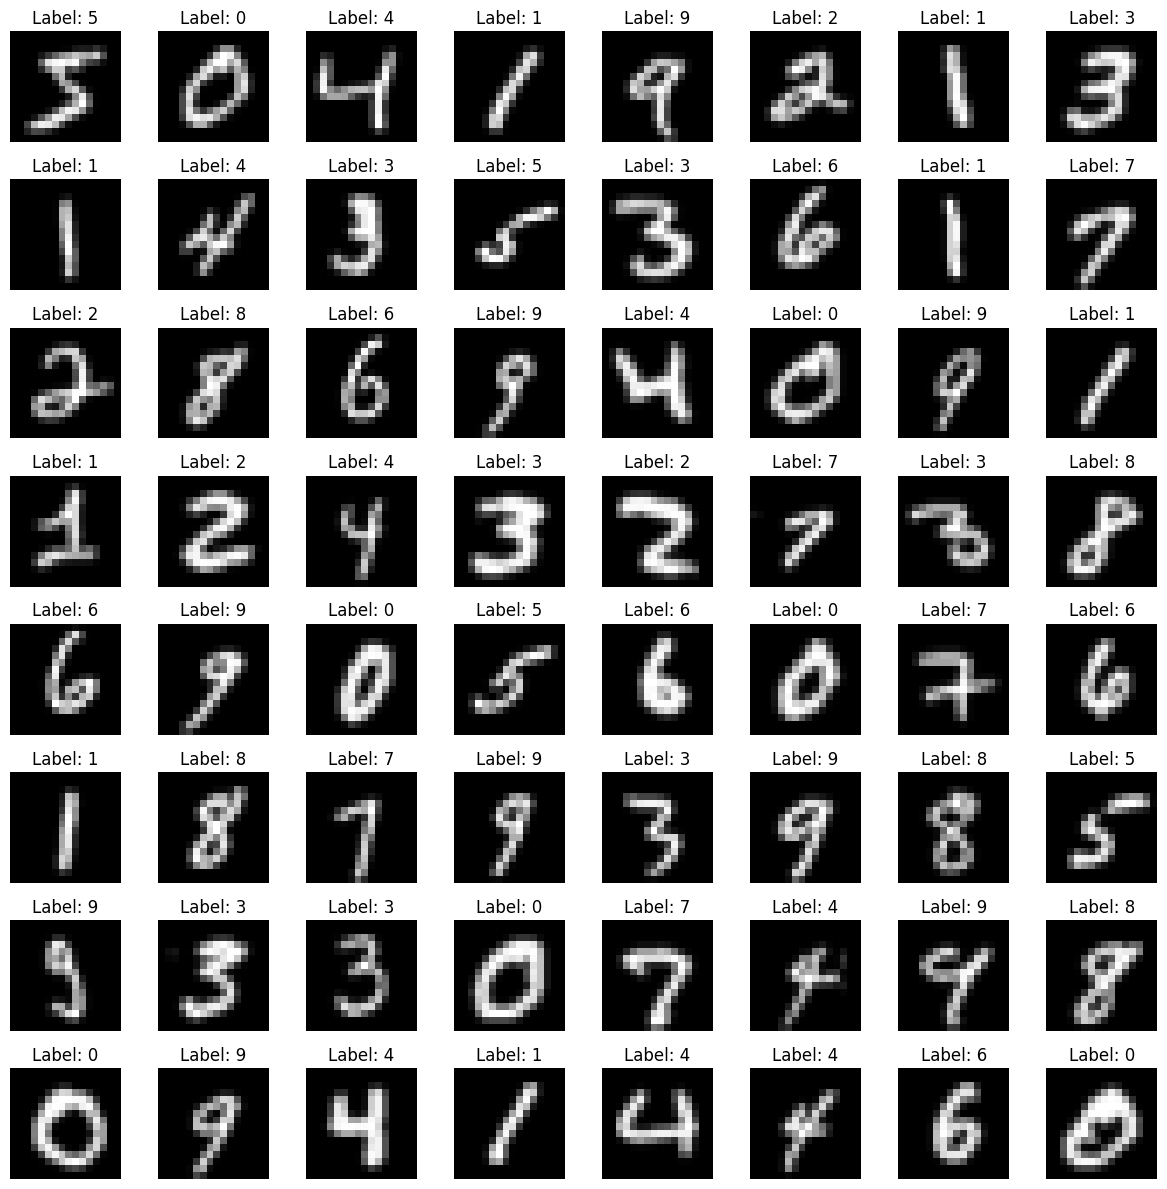

In [6]:
# Fetch a batch of images and labels from the training dataloader
example_batch = next(iter(train_dataloader))
images, labels = example_batch

# Plot the images in a grid format (8x8 grid for a batch of size 64)
plt.figure(figsize=(12, 12))
for i in range(64):  # Assuming a batch size of 64
    plt.subplot(8, 8, i + 1)  # 8x8 grid of subplots
    plt.imshow(images[i].squeeze(), cmap="gray")  # Remove the channel dimension and plot as grayscale
    plt.title(f"Label: {labels[i].item()}")  # Show label for each image
    plt.axis('off')  # Hide the axes for clarity

plt.tight_layout()  # Ensure no overlap between subplots
plt.show()  # Display the grid

In [7]:
# Define a custom optimizer that uses an approximation of the diagonal of the Hessian matrix
# to adaptively scale the learning rate during training (Newton's method-like update)
# This is how the LeCun has done it.
class DiagonalHessianOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-2, damping=1e-5):
        defaults = dict(lr=lr, damping=damping)
        super(DiagonalHessianOptimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        # Calculate the loss if a closure is provided
        loss = None
        if closure is not None:
            loss = closure()

        # Update the parameters based on the approximated Hessian diagonal
        for group in self.param_groups:
            lr = group['lr']
            damping = group['damping']

            for p in group['params']:
                if p.grad is None:
                    continue

                # Compute the squared gradient as an approximation of the Hessian diagonal
                hessian_diag_approx = p.grad.data ** 2

                # Apply the Newton-like update with diagonal Hessian approximation
                update = p.grad.data / (hessian_diag_approx + damping)
                
                # Update parameters
                p.data = p.data - lr * update

        return loss


In [8]:
# Define a PyTorch Lightning wrapper for the LeNet2 model
class LeNet2_Lit(L.LightningModule):
    def __init__(self):
        super().__init__()
        # Initialize the model architecture
        self.model = LeNet2()
        # Define the loss function as MSELoss
        self.loss = nn.MSELoss()

    def forward(self, x):
        # Forward pass through the model
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # Training step: Calculate loss, error, and log them
        x, y = batch
        y = nn.functional.one_hot(y, num_classes=10).float()  # Convert labels to one-hot encoding
        y_prime = self.model(x)
        loss = self.loss(y_prime, y)
        
        # Calculate accuracy (number of correct predictions)
        correct_predictions = (torch.argmax(y_prime, dim=1) == torch.argmax(y, dim=1)).sum().float()
        accuracy = correct_predictions / y.size(0)
        
        # Calculate prediction error as 1 - accuracy
        prediction_error = 1 - accuracy
        
        # Log loss and prediction error during training
        self.log('train/loss', loss, prog_bar=True)
        self.log('train/error', prediction_error, prog_bar=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        # Validation step: Similar to training step, but only for validation data
        x, y = batch
        y = nn.functional.one_hot(y, num_classes=10).float()
        y_prime = self.model(x)
        loss = self.loss(y_prime, y)
        
        # Calculate accuracy (number of correct predictions)
        correct_predictions = (torch.argmax(y_prime, dim=1) == torch.argmax(y, dim=1)).sum().float()
        accuracy = correct_predictions / y.size(0)
        
        # Calculate prediction error as 1 - accuracy
        prediction_error = 1 - accuracy
        
        # Log loss and prediction error during validation
        self.log('val/loss', loss, prog_bar=True)
        self.log('val/error', prediction_error, prog_bar=True)
        
    def configure_optimizers(self):
        # Use the custom DiagonalHessianOptimizer with learning rate 1e-5
        optimizer = DiagonalHessianOptimizer(self.parameters(), lr=1.e-5)
        return optimizer


In [9]:
# Print a summary of the model to understand its architecture and parameter counts
from lightning.pytorch.utilities.model_summary import ModelSummary
model = LeNet2_Lit()
summary = ModelSummary(model, max_depth=2)  # Limit the depth of the summary
print(summary)


  | Name              | Type    | Params
----------------------------------------------
0 | model             | LeNet2  | 10.0 K
1 | model.h1          | Conv2d  | 312   
2 | model.h2          | Conv2d  | 3.6 K 
3 | model.h3          | Linear  | 5.8 K 
4 | model.output_unit | Linear  | 310   
5 | model.activation  | Tanh    | 0     
6 | loss              | MSELoss | 0     
----------------------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)


In [10]:
# Set up a CSVLogger to track training and validation metrics
from lightning.pytorch.loggers import CSVLogger

# Initialize the CSVLogger to store logs in the current directory
csv_logger = CSVLogger('.')

# Set up the PyTorch Lightning Trainer to train for 23 epochs, use the CSVLogger, and specify the validation data
trainer = L.Trainer(max_epochs=23, logger=csv_logger)

# Train the model using the trainer
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs

  | Name  | Type    | Params
----------------------------------
0 | model | LeNet2  | 10.0 K
1 | loss  | MSELoss | 0     
----------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=23` reached.


# Loss and Metrics 

In [11]:
import pandas as pd
import seaborn as sns
import numpy as np

In [12]:
df = pd.read_csv('lightning_logs/version_0/metrics.csv')

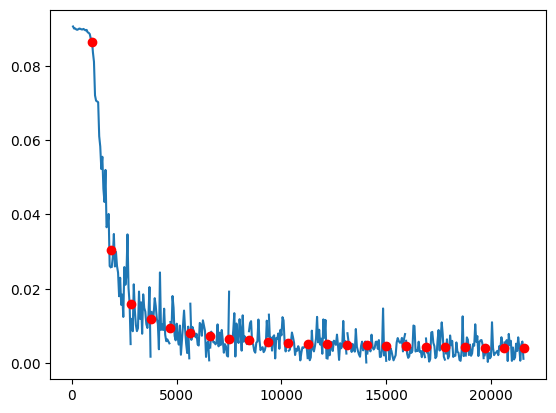

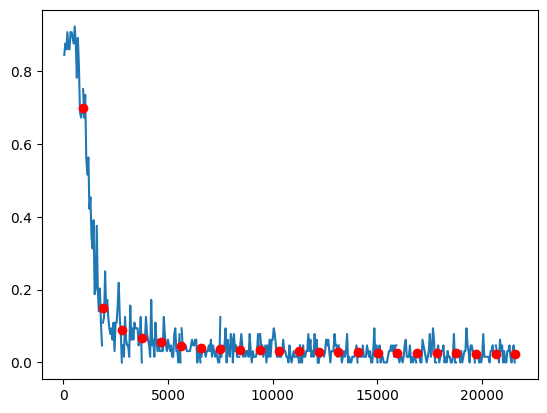

In [13]:
plt.figure()
plt.plot(df['step'], df['train/loss'])
plt.plot(df['step'], df['val/loss'],'or')
plt.show()

plt.figure()
plt.plot(df['step'], df['train/error'])
plt.plot(df['step'], df['val/error'],'or')
plt.show()

In [14]:
accuracy_list = []
model.eval()
with torch.no_grad():
    
    for batch in train_dataloader:
        x,y = batch
        y_prime = model(x)
        # Calculate accuracy (number of correct predictions)
        correct_predictions = (torch.argmax(y_prime, dim=1) == y).sum().float()
        accuracy = correct_predictions / y.size(0)
        
        accuracy_list.append(accuracy.item())
        
np.array(accuracy_list).mean()

0.9816098081023454

In [15]:
accuracy_list = []
model.eval()
with torch.no_grad():
    
    for batch in val_dataloader:
        x,y = batch
        y_prime = model(x)
        # Calculate accuracy (number of correct predictions)
        correct_predictions = (torch.argmax(y_prime, dim=1) == y).sum().float()
        accuracy = correct_predictions / y.size(0)
        
        accuracy_list.append(accuracy.item())
        
np.array(accuracy_list).mean()

0.9767117834394905